In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import svm
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import decomposition

# Dataset loading
The training data for the problem is loaded and it is subdivided into training and testing sets to leave the test dataset as a validation set

In [2]:
X = np.loadtxt('xtrain.txt')
Y = np.loadtxt('ytrain.txt')
x_v = np.loadtxt('xtest.txt')

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2)

# Preprocessing
In problems such as logistic classification and neural network classification, there was an apparent benefit from standardizing the data, which is the reason for doing so here.

# The approach
A SVM approach will be used. For this problem, the $ \nu$SVC and the CSVC will be used to determine which one produces better results when their parameters are properly adjusted, for the polynimial and Gaussian kernels

# $ \nu$SVC Gaussian
This is a good choice when the data can be properly separated without considering an intercept. This isn't known for this dataset and the number of features makes it impossible to get a visual representation of the data, which is the reason why the two approaches for SVM are tested. The performance for a logarithmic grid of the parameter $ \nu$ will be tested by using different error criterions, such as accuracy of the classifier on the testing and training datasets and cross validation.

# Plain old accuracy
In this case, the accuracy is estimated on a training dataset and a validation dataset. For a big enough amount of testing data, the estimated real error is close to its true value, however, choosing the best classifier based on this criterion alone, makes said classifier dependent on the testing data.

In [3]:
scaler=preprocessing.StandardScaler().fit(X_train)
X_trains=scaler.transform(X_train)
X_tests=scaler.transform(X_test)
scores_train = np.zeros(25)
scores_test = np.zeros(25)
grid = np.linspace(0.05,0.90,25)
for i in range(25):
    nusvc = svm.NuSVC(nu=grid[i], kernel='rbf')
    nusvc.fit(X_trains, Y_train)
    scores_train[i] = nusvc.score(X_trains, Y_train)
    scores_test[i] = nusvc.score(X_tests, Y_test)

# Goodness of classification
The goodness of the classification is evaluated by measuring the mean accuracy of the classifier in the test samples, and comparing it to the training samples to annalize the error and the overfitting of the model.

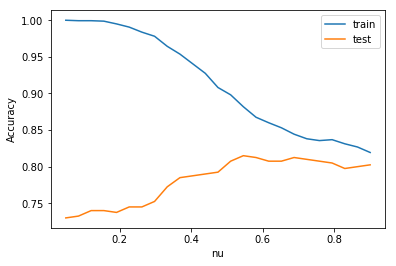

In [4]:
import matplotlib.pyplot as plt
plt.plot(grid, scores_train, label='train')
plt.plot(grid, scores_test, label='test')
plt.xlabel('nu')
plt.ylabel('Accuracy')
plt.legend()

It is clearly seen that there is little difference for the training an testing datasets, and the results are very poor for low values of $ \nu$. THe best accuracy is seen for a value of 0.7 with:

In [5]:
nusvc = svm.NuSVC(nu=0.7, kernel='rbf')
nusvc.fit(X_trains, Y_train)
print('The mean accuracy on the training samples is: %f' %(nusvc.score(X_trains, Y_train)))
print('The mean accuracy on the testing samples is: %f' %(nusvc.score(X_tests, Y_test)))

The mean accuracy on the training samples is: 0.841875
The mean accuracy on the testing samples is: 0.810000


# Cross validation

It is thought that in certain cases it offers a better approach to the real classification error by reducing the variance, however one problem that it presents is that the estimated errors used to compute the average error, are not independent so the resulted average may have a different meaning, and it is not so easy to find a bound in this case.

In order to ensure that the classifier does not depend on the data a testing set of 2048 samples will be reserved and won't be used during the exploration to find the optimal number of neurons.

For cross validation the training data will be split randomly in 10 bins and one of them will be seclected to compute a total of 10 errors per iteration which will be averaged to give the score.

In [6]:
scores = np.zeros(25)
for i in range(25):
    nusvc = svm.NuSVC(nu=grid[i], kernel='rbf')
    scores[i] = np.mean(np.array(model_selection.cross_val_score(nusvc, X_trains, Y_train, cv=10)))

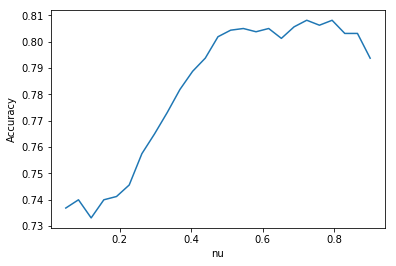

In [7]:
plt.plot(grid, scores)
plt.xlabel('nu')
plt.ylabel('Accuracy')

It can be seen that the accuracies are pretty much the same for the two error criterions, which means the best classifier is found with a Gaussuan kernel for the $ \nu$SVC, by taking into account accuracy and overfitting, however it is worth taking a look at CSVC to compare the results.

# CSVC

In this case an intercept is considered, so it is possible that this method yields better results.

In [8]:
scores_train = np.zeros(25)
scores_test = np.zeros(25)
grid = np.logspace(-1.,4.,25)
for i in range(25):
    svc = svm.SVC(C=grid[i], kernel='rbf')
    svc.fit(X_trains, Y_train)
    scores_train[i] = svc.score(X_trains, Y_train)
    scores_test[i] = svc.score(X_tests, Y_test)

# Goodness of classification

# Plain old accuracy

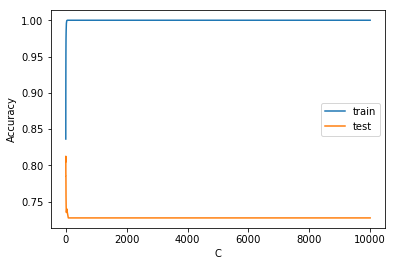

In [9]:
plt.plot(grid, scores_train, label='train')
plt.plot(grid, scores_test, label='test')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

It is clearly seen that there is little difference for the training an testing datasets, and is pretty much the samne for all values of C. With 8000:

In [10]:
svc = svm.SVC(C=8000, kernel='rbf')
svc.fit(X_trains, Y_train)
print('The mean accuracy on the training samples is: %f' %(svc.score(X_trains, Y_train)))
print('The mean accuracy on the testing samples is: %f' %(svc.score(X_tests, Y_test)))

The mean accuracy on the training samples is: 1.000000
The mean accuracy on the testing samples is: 0.727500


# Cross validation

In this case there is no clear difference among different values of C, howevwer crossvalidation may offer a better insight.

In [11]:
scores = np.zeros(25)
for i in range(25):
    svc = svm.SVC(C=grid[i], kernel='rbf')
    scores[i] = np.mean(np.array(model_selection.cross_val_score(svc, X_trains, Y_train, cv=10)))

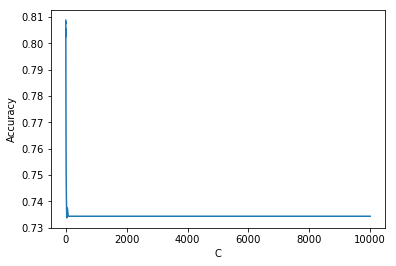

In [12]:
plt.plot(grid, scores)
plt.xlabel('C')
plt.ylabel('Accuracy')

According to this, the best classifier is the $ \nu$SVC with a value of 0.7 for $ \nu$, using a Gaussian kernel. Fort this reason, this classifier is used for all the samples in order to produce labels for the given validation set.

With 400 samples in the testing dataset, it is possible to use Chernoff's absolute error bounds to ensure with a confidence of 95%, that:

$$ e=\sqrt{\frac{1}{2*400}\frac{1}{\ln(\frac{1}{0.025})}}\approx 0.02 $$

In [13]:
Xs = scaler.transform(X)
svc = svm.NuSVC(nu=0.7, kernel='rbf')
svc.fit(Xs, Y)
labels = svc.predict(scaler.transform(x_v))
np.savetxt('labels_gauss.dat', labels)